# <span style="color:blue"> Binary Segmentation with the U-Net Model

**Segmenting a single object** - the ```Multiple Sclerosis``` dataset

In this notebook, we will train a U-Net model to perform semantic segmentation on RGB images of cars from the **Multiple Sclerosis dataset**. The objective of this task is to accurately separate the lesions from their background.

<span style="color:red"> **Before proceeding**, ensure the dataset is available at ```D:\PIR_SEP\Datasets\BRAIN_MRI_SLICES```  

<span style="color:black">

The **U-Net** architecture is ideal for this task because it combines a contracting path (encoder) and an expanding path (decoder). This design effectively captures both high-level global features and fine-grained local details.

This notebook will guide you through the following steps:
>1. **Imports:** Setting up required libraries and packages.
>2. **Data Loading and Visualization:** Understanding the dataset and preprocessing it for the task.
>3. **Network Architecture Definition:** Implementing the U-Net model.
>4. **Model Training:** Optimizing the network with backpropagation.
>5. **Inference and Evaluation:** Testing the model on unseen data and assessing its performance using relevant metrics.

---

### <span style="color:brown"> **What is Segmentation?**

Segmentation involves assigning a class label to every pixel in an image.

- **Binary Segmentation:** Identifies a single object class (e.g., car) against the background.
- **Multi-Class Segmentation:** Differentiates between multiple object classes.

---

### <span style="color:brown"> **Semantic vs. Instance Segmentation**

When multiple objects of the same class appear in an image:
- **Semantic Segmentation:** Assigns the same label to all objects of the same class.
- **Instance Segmentation:** Differentiates and labels each object instance separately, enabling object counting.

Instance separation can sometimes be performed using traditional image processing techniques after semantic segmentation.

<img src="figures/SemanticIntanceSegmentation.png" alt="Semantic vs Instance Segmentation" style="width: 75%;"/>

**In this notebook, we focus on semantic segmentation** using the U-Net deep learning architecture.

---

### <span style="color:brown"> **A Quick Overview of U-Net**

The U-Net architecture is a fully **convolutional network** designed for segmentation tasks. Its key features include:
- **Skip connections:** Directly link the encoder and decoder layers to preserve spatial details and scale information.
- **Symmetrical design:** Combines downsampling for context (**encoder in orange**) with upsampling for precise localization (**decoder in green**).

<img src="figures/UNet.png" alt="U-Net Architecture" style="width: 70%;"/>


## <span style="color:brown"> 1. Imports 
Before we begin, we will import the necessary libraries for data handling, image transformations, and model training using PyTorch.

In [1]:
# Import libraries
# PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torch import Tensor

# Torchvision for data transformations
import torchvision
from torchvision import datasets, transforms

# Torchinfo to display model summaries
from torchinfo import summary

# Numpy and Pathlib for data handling
import numpy as np
from pathlib import Path

# Tqdm for progress bars
from tqdm.auto import tqdm

# Import the 'os' module, which provides functions for interacting with the operating system.
# This module is useful for tasks like handling file paths, creating directories, and managing files.
import os

# Import specific types from the 'typing' module, which provides support for type hints in Python.
# 'Optional' is used for indicating that a variable might be of a certain type or None.
# 'Union' allows a variable to be one of several types.
# 'Tuple' is used to specify a fixed-size sequence of elements of specified types.
from typing import Optional, Union, Tuple

# Monai for medical imaging, specific to preprocessing and loss functions
import monai
from monai.transforms import LoadImage
# from monai.losses import DiceLoss

# Matplotlib for data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Import the 'glob' module, which provides a way to retrieve files matching a specified pattern. 
# This is useful for loading multiple image and mask files from directories.
import glob
# Import the 'Image' class from the 'PIL' (Python Imaging Library) module.
# This class allows us to open, manipulate, and save various image file formats.
from PIL import Image

# Check and display library versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")

import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

#import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm


PyTorch version: 2.2.0
Torchvision version: 0.17.0
Numpy version: 1.26.4
Monai version: 1.4.1rc1+46.gb58e883c


In [2]:

# Device setup
# Use GPU if available for faster training, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
!which python



Using device: cuda
True
2.2.0
12.1
8801
/c/Users/sofia/anaconda3/envs/monai-dev/python


--- 
## <span style="color:brown"> 2. Load and Visualize the Data
In this section, we load and visualize RGB images from the carvana dataset.

Datasets often require preprocessing steps to prepare the data for training. Here, we will visualize a few examples to understand what our model will learn to segment. 
    

### <span style="color:brown"> 2.1 Create Dataset objects
`SepDataset`  will be used to load the data during training, validating and testing.

In [3]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset

# Transformation personnalisée pour redimensionner l'image et le masque
class ResizeImageAndMask:
    def __init__(self, image_size, mask_size):
        #on redimensionne pour :
        #Uniformiser toutes les images (et masques) à une taille standard
        #Permettre des batchs (traiter plusieurs images à la fois)
        #Faire tourner le modèle sans crash
        
        #Quand tu redimensionnes une image, tu perds des pixels (ou tu en inventes, si tu agrandis).
        #→ L’interpolation est juste la méthode utilisée pour remplir les trous ou lisser la transition.

        # Redimensionner l'image avec interpolation bilinéaire, fait une moyenne des pixels voisins
        self.image_resize = transforms.Resize(image_size, interpolation=Image.BILINEAR)
        # Redimensionner le masque avec interpolation nearest (voisinage), plus proche voisin, si tu fais une interpolation bilinéaire, tu risques d’avoir des valeurs entre 0 et 1, genre 0.3, 0.8... ce qui n’a aucun sens pour un masque binaire
        self.mask_resize = transforms.Resize(mask_size, interpolation=Image.NEAREST)

    def __call__(self, sample):
        # Sample est un tuple (image, mask)
        image, mask = sample
        image = self.image_resize(image)
        mask = self.mask_resize(mask)
        return image, mask


class SepDataset(Dataset):
    #  def __init__(self, image_paths, mask_paths, resized_width, resized_height, limit=None):
    #limit = nombre limité de couples image/mask
    def __init__(self, root_path, resized_width, resized_height,limit=None):
        self.root_path = root_path
        self.limit = limit
        # Liste des chemins des images et des masques
        #trier les images et les masques (pour que image <-> mask reste aligné) et en prendre jusqu'à la limite définie
        self.images = sorted(
            [os.path.join(root_path, "train_data", i) 
             for i in os.listdir(os.path.join(root_path, "train_data")) 
             if i.endswith(".png")]
        )[:self.limit]
        
        self.masks = sorted(
            [os.path.join(root_path, "train_seg", i) 
             for i in os.listdir(os.path.join(root_path, "train_seg")) 
             if i.endswith(".png")]
        )[:self.limit]

        #définir la taille des images et des masques
        self.resized_width = resized_width
        self.resized_height = resized_height
        # Définir la transformation composée
        self.transform = transforms.Compose([
             ResizeImageAndMask((resized_width, resized_height), (resized_width, resized_height)),  # Redimensionner l'image et le masque
 
        ])

        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        # Charger l'image et le masque
        img = Image.open(self.images[index]).convert("L")
        mask = Image.open(self.masks[index]).convert("L") #luminance = noir et blanc

        # Appliquer la transformation composée (l'image et le masque doivent être passés comme un tuple)
        img, mask = self.transform((img, mask))  # Passer le tuple à la transformation

        # Convertir l'image en tenseur
        img = transforms.ToTensor()(img)

        # Vérifier la valeur maximale de l'image après la conversion en tenseur
        if img.max() > 1.0:  # Si l'image est dans la plage [0, 255]
            img = img / 255.0  # Normaliser les pixels dans la plage [0, 1]

        # Normalisation de l'image entre [-1, 1]
        img = (img - 0.5) / 0.5  # Normalisation de l'image

        # Convertir le masque en tenseur et binariser
        mask = transforms.ToTensor()(mask)  # Convertir le masque en tenseur
        mask = (mask > 0).float()  # Binariser le masque (0 ou 1)

        # Retourner l'image transformée, le masque transformé et le chemin de l'image
        return img, mask, self.images[index]

    def __len__(self):
        return min(len(self.images), self.limit)


### <span style="color:brown"> 2.2 - Load Files and Create Datasets

The ```SepDataset``` class is responsible for loading and formatting the data. It ensures that:
- The **size** of the images and masks (labels) is adjusted to the desired dimensions using resizing transformations.
- The **range** of pixel values is normalized:
  - **Images:** Normalized to the range [-1, 1] after being scaled to [0, 1].
  - **Masks:** Binarized to contain only 0 or 1 values after conversion to tensors.
- The **type** of images and masks is compatible with PyTorch:
  - Images are converted to `float32` tensors.
  - Masks are also converted to `float32` tensors but remain binary.

#### Using the Entire Dataset
To process the entire dataset, simply **omit the `limit` parameter** when calling the ```SepDataset``` class. If a value is provided for `limit`, only the specified number of samples will be loaded, which can be useful for debugging or testing.

```python
dataset = SepDataset(root_path="D:\PIR_SEP\Datasets\BRAIN_MRI_SLICES", resized_width=128, resized_height=128, limit=None)


In [4]:
width=304   # width of images/masks processed by the network
height=752  # height of images/masks processed by the network
#print(os.listdir("./."))

DATASET_DIR = 'D:/PIR_SEP/Datasets/BRAIN_MRI_SLICES'
train_dataset = SepDataset(DATASET_DIR,resized_width=width,resized_height=height)        # Full database
#train_dataset = CarvanaDataset(DATASET_DIR,resized_width=width,resized_height=height,limit=500) # only 500 samples of the database
# Initial size of the images is (1918,1280) coded in RGB. 
# The previous function change the size of these images and their corresponding mask (label).

#Si tu n'utilisais pas de générateur, la division serait différente à chaque exécution du code.
generator = torch.Generator().manual_seed(25)
#diviser le dataset en dataset d'entraînement et de test de manière random avec 0.8 train et 0.2 test en utilisant les générateur
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
print("Size dataset :",len(train_dataset)+len(test_dataset))
print("Size train_dataset :",len(train_dataset))
print("Size test_dataset :",len(test_dataset))

#diviser le dataset de test en dataset de test et de validation à 0.5 et 0.5 en utilisant le générateur
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)
print("Size train_dataset :",len(train_dataset))
print("Size test_dataset :", len(test_dataset))
print("Size val_dataset :", len(val_dataset))

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    num_workers = torch.cuda.device_count() * 4 - 1 #L'idée de multiplier par 4 et soustraire 1 est une méthode pour utiliser efficacement les ressources disponibles.
#num_workers = 1  # cmu
print("device :",device)
print("num_workers :",num_workers)

LEARNING_RATE = 3e-4 #Le learning rate (taux d'apprentissage) détermine à quel point les poids du modèle doivent être ajustés pendant l'entraînement à chaque itération.
BATCH_SIZE = 8  # 1   #  4, 8, 16, 32 Le batch size (taille du lot) détermine combien d'exemples seront traités simultanément dans chaque passage du modèle pendant l'entraînement.


Size dataset : 59
Size train_dataset : 48
Size test_dataset : 11
Size train_dataset : 48
Size test_dataset : 6
Size val_dataset : 5
device : cuda
num_workers : 3


In [5]:
#Création des objets DataLoader pour charger les données d'entraînement, de validation et de test dans des mini-lots (batches) pendant l'entraînement de ton modèle.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Cela signifie que les données seront mélangées à chaque époque pour éviter que le modèle apprenne de manière séquentielle et n'intègre pas des biais liés à l'ordre des données.
val_dataloader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle= False) #Les données de validation ne sont pas mélangées. Cela permet de toujours tester le modèle sur les mêmes données à chaque époque pour une évaluation stable.
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE, shuffle=False) #Comme pour la validation, les données de test ne sont pas mélangées pour garantir une évaluation cohérente.

In [6]:
# Vérification du DataLoader
for img, mask, path in  test_dataloader:
    print(f'Image batch shape: {img.shape}') #nbre d'images dans le batch, nombre de canaux (3 pour RGB, 1 pour L), hauteur, largeur)
    print(f'Mask batch shape: {mask.shape}')
    print(f'Image path: {path[0]}')  # Afficher un chemin d'image pour vérifier
    break  # Juste pour vérifier une première itération


Image batch shape: torch.Size([6, 1, 304, 752])
Mask batch shape: torch.Size([6, 1, 304, 752])
Image path: D:/PIR_SEP/Datasets/BRAIN_MRI_SLICES\train_data\Patient-59_59-Flair.png


In [7]:
# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)
batch_data = next(test_dataloader_iter) #retourne le prochain lot de données. Ce lot contient une image et son masque associé label. batch_data est une tupla: image, mask
image, label = batch_data[0].to(device), batch_data[1].to(device)
print("image.shape",image.shape)     
print("label.shape",label.shape) 
print("torch.max(label): ",torch.max(label)) #la plus grande valeur du mask
print("torch.max(imag): ",torch.max(image)) #la plus grande valeur de l'image


image.shape torch.Size([6, 1, 304, 752])
label.shape torch.Size([6, 1, 304, 752])
torch.max(label):  tensor(1., device='cuda:0')
torch.max(imag):  tensor(1., device='cuda:0')


train_idx: 4
val_idx: 1
test_idx: 2


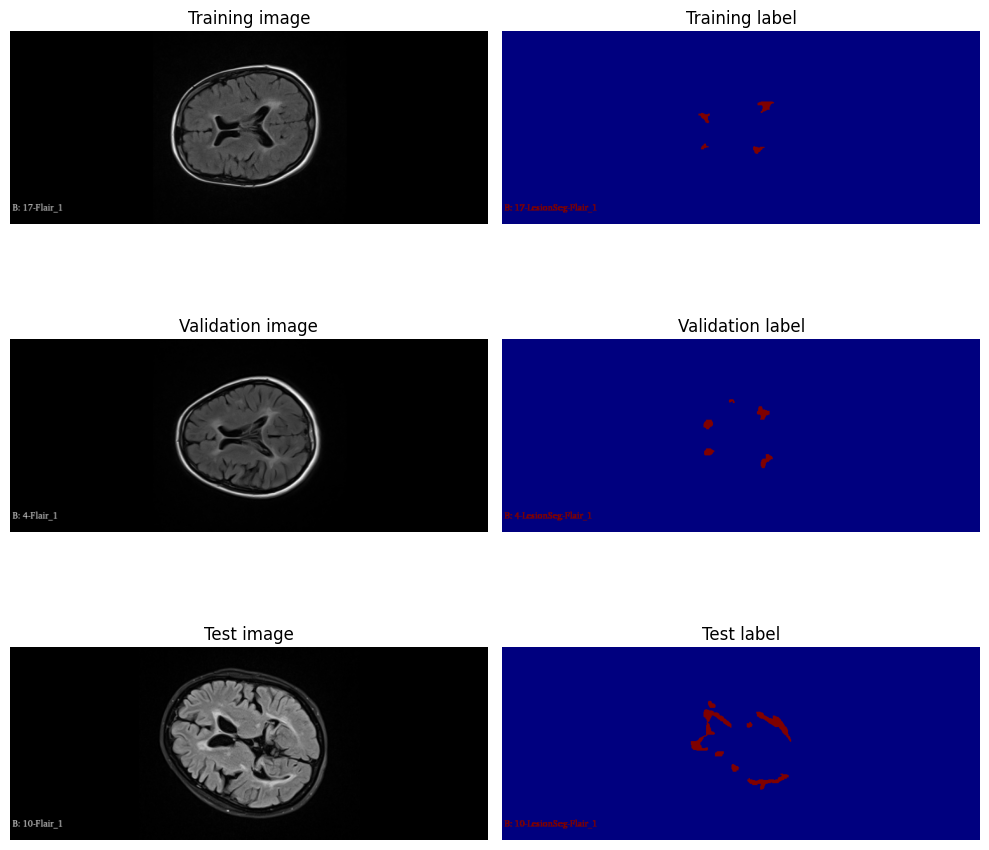

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get a random index for each dataset
train_idx = np.random.randint(len(train_dataset))
val_idx = np.random.randint(len(val_dataset))
test_idx = np.random.randint(len(test_dataset))

print("train_idx:", train_idx)
print("val_idx:", val_idx)
print("test_idx:", test_idx)

figure = plt.figure(figsize=(10, 10))

def display_image_and_label(image, label, row, title_prefix):
    # Déplacer vers CPU et numpy
    image = image.detach().cpu().numpy()
    label = label.detach().cpu().numpy()

    # Normalisation : [-1, 1] → [0, 1]
    image = (image + 1) / 2.0

    # Squeeze les dimensions inutiles
    image = np.squeeze(image)  # Devient (H, W) ou (H, W, C) selon le cas
    label = np.squeeze(label)

    ax = figure.add_subplot(3, 2, row * 2 - 1)
    if image.ndim == 2:
        ax.imshow(image, cmap='gray')  # Image en niveaux de gris
    elif image.ndim == 3:
        ax.imshow(np.transpose(image, (1, 2, 0)))  # (C, H, W) → (H, W, C)
    else:
        raise ValueError(f"Format image inattendu: {image.shape}")
    ax.set_title(f"{title_prefix} image")
    ax.axis('off')

    ax = figure.add_subplot(3, 2, row * 2)
    ax.imshow(label, cmap='jet', alpha=1)
    ax.set_title(f"{title_prefix} label")
    ax.axis('off')

# 1. Train
batch_data = train_dataset[train_idx]
image, label = batch_data[0].to(device), batch_data[1].to(device)
display_image_and_label(image, label, 1, "Training")

# 2. Validation
batch_data = val_dataset[val_idx]
image, label = batch_data[0].to(device), batch_data[1].to(device)
display_image_and_label(image, label, 2, "Validation")

# 3. Test
batch_data = test_dataset[test_idx]
image, label = batch_data[0].to(device), batch_data[1].to(device)
display_image_and_label(image, label, 3, "Test")

# Layout final
figure.tight_layout()
plt.show()


---
## <span style="color:brown"> 3. Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The U-Net model for binary segmentation takes a batch of input images and processes each image to output **a corresponding probability map**. Each pixel in this map represents the likelihood that the pixel belongs to the target object class. 

Since we’re performing binary segmentation, the output for each image is a single-channel tensor, where each pixel value ranges between 0 and 1. A value closer to 1 indicates a higher probability that the pixel is part of the target object, while a value closer to 0 suggests background.

This approach allows the model to efficiently learn the spatial structure of the objects within the images, providing pixel-wise predictions for accurate segmentation.

### <span style="color:brown"> 3.1 Model Architecture Parameters

In [10]:
# Model Architecture Parameters
input_channels = 1    #e.g. 3 for RGB, 1 for grayscale input images
num_classes  = 1      #  e.g. 1 for binary segmentation (background vs object)
input_shape = (input_channels, width, height)  # This is the shape of the input image to the network
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32              # This is the number of channels in the first layer of the network
# Nombre de filtres appliqués à l’image dans la 1ère couche
#Chaque filtre apprend à détecter quelque chose de différent :
#un peut détecter des bords horizontaux,
#un autre les coins,
#un autre une texture spécifique, etc.

### <span style="color:brown">3.2 Model Architecture</span>

In this section, two distinct model architectures are provided. However, you should only use one model for your task. Please select and activate the corresponding cell below based on your preferred model choice.

#### <span style="color:brown">Comparison of MONAI's `UNet` and Custom `UNet` Model in PyTorch</span>

When working with U-Net architectures for image segmentation, both **MONAI**'s `UNet` and a **custom PyTorch U-Net** can be used. However, they offer different levels of abstraction, flexibility, and usability. Below is a comparison of these two approaches:



##### <span style="color:brown">MONAI `UNet` Model</span> (from `monai.networks.nets`)

- **Purpose**: MONAI is a framework specifically designed for medical imaging tasks, built on top of PyTorch.
  
- **Ease of Use**: MONAI provides a high-level interface that simplifies the process of creating U-Net models. It allows users to quickly configure and instantiate a U-Net model by specifying only a few parameters, such as the number of input and output channels, the number of feature channels, and other configuration parameters like the stride and number of residual units.

- **Customizability**: While MONAI's `UNet` is highly configurable with parameters like `channels`, `strides`, and `num_res_units`, it hides some of the underlying complexity of U-Net, making it suitable for users who want an easy-to-implement model. 

- **Key Features**:
  - Optimized for 2D and 3D medical image segmentation.
  - Predefined configurations for common tasks, reducing setup time.
  - Focus on usability for medical AI tasks.


##### <span style="color:brown">Custom U-Net Model in PyTorch</span>

- **Purpose**: A custom U-Net implementation in PyTorch provides full flexibility, allowing users to define the architecture according to their specific needs. This model can be used for both general and specialized image segmentation tasks, not just medical imaging.

- **Flexibility**: The custom implementation allows for fine-grained control over every aspect of the network architecture. You can modify the number of layers, types of layers, normalization methods, upsampling techniques, and more.

- **Complexity**: Writing a custom U-Net requires more effort as you must manually define each block (e.g., convolution layers, downsampling, and upsampling). This gives more control over the implementation but increases the amount of code and complexity.

- **Customizability**: You can adjust various hyperparameters, such as the type of convolution (`Conv2d` or `ConvTranspose2d`), batch normalization, dropout rates, and even the use of bilinear interpolation or transposed convolutions for upsampling.

- **Key Features**:
  - Full control over architecture.
  - Greater flexibility to modify layer types and network structure.
  - Ideal for users who need customization for specific segmentation tasks.



##### <span style="color:brown">Comparison Table</span>

| **Feature**                        | **MONAI `UNet`**                                  | **Custom PyTorch `UNet`**                      |
|------------------------------------|--------------------------------------------------|-----------------------------------------------|
| **Ease of Use**                    | High (dedicated for medical image segmentation)   | Low (manual implementation required)          |
| **Flexibility**                    | Moderate (configurable parameters)               | High (full control over architecture)         |
| **Customizability**                | Low (limited to predefined blocks and parameters) | High (customize every part of the network)     |
| **Code Complexity**                | Low (simple instantiation)                       | High (requires manual architecture design)    |
| **Intended Use Case**              | Medical imaging segmentation                     | General segmentation tasks                    |


### <span style="color:brown"> First Model Architecture 

In [11]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 2,                 # 2D U-Net
    in_channels = 1,     # Canaux d'entrée (3)
    out_channels = 1,       # Canaux de sortie (classes de segmentation)
    channels = (16, 32, 64, 128),     # Nombres de canaux aux différents niveaux d'encodage
    #1	Entrée → conv	16
    #2	conv → pooling	32
    #3	conv → pooling	64
    #4	Bottleneck	128: Compresser l'information visuelle, Extraire des représentations abstraites (ex: "ça ressemble à une voiture", "y'a un contour ici"), Garder seulement l’essentiel avant de reconstruire.
    #Dans la phase de décodage, ces nombres sont utilisés à l’envers avec upsampling
    strides = (2, 2, 2),              # Strides de downsampling: chaque stride contrôle la taille de sortie de l’étape suivante
    #2 veut dire qu’on divise par 2 à chaque fois 
    num_res_units=1                   # Nombre d'unités résiduelles par bloc: plus = plus profond localement
).to(device)


### <span style="color:brown"> Second Model Architecture 

In [12]:
class UNet(nn.Module):
    """Architecture based on U-Net: Convolutional Networks for Biomedical Image Segmentation.

    References:
    - Paper that introduced the U-Net model: https://arxiv.org/abs/1505.04597
    """

    def __init__(
        self,
        input_shape: Tuple[int, ...],
        output_shape: Tuple[int, ...],
        init_channels: int = 32,
        use_batchnorm: bool = True,
        bilinear: bool = False,
        dropout: float = 0.0,
    ):
        """Initializes class instance.

        Args:
            input_shape: (in_channels, H, W), Shape of the input images.
            output_shape: (num_classes, H, W), Shape of the output segmentation map.
            init_channels: Number of output feature maps from the first layer, used to compute the number of feature
                maps in following layers.
            use_batchnorm: Whether to use batch normalization between the convolution and activation layers in the
                convolutional blocks.
            bilinear: Whether to use bilinear interpolation or transposed convolutions for upsampling.
            dropout: Probability of an element to be zeroed (e.g. 0 means no dropout).
        """
        super().__init__()
        in_channels = input_shape[0]
        out_channels = output_shape[0]

        self.layer1 = _DoubleConv(in_channels, init_channels // 2, dropout / 2, use_batchnorm)
        self.layer2 = _Down(init_channels // 2, init_channels, dropout, use_batchnorm)
        self.layer3 = _Down(init_channels, init_channels * 2, dropout, use_batchnorm)
        self.layer4 = _Down(init_channels * 2, init_channels * 4, dropout, use_batchnorm)

        self.layer5 = _Up(
            init_channels * 4, init_channels * 2, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer6 = _Up(
            init_channels * 2, init_channels, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer7 = _Up(init_channels, init_channels // 2, 0, use_batchnorm, bilinear=bilinear)

        self.layer9 = nn.Conv2d(init_channels // 2, out_channels, kernel_size=1)

        # Use Xavier initialisation for weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x: Tensor) -> Tensor:
        """Defines the computation performed at every call.

        Args:
            x: (N, ``in_channels``, H, W), Input image to segment.

        Returns:
            (N, ``out_channels``, H, W), Raw, unnormalized scores for each class in the input's segmentation.
        """
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        out = self.layer5(x4, x3)
        out = self.layer6(out, x2)
        out = self.layer7(out, x1)

        return self.layer9(out)


class _DoubleConv(nn.Module):
    """Double Convolution and BN and ReLU.

    (3x3 conv -> BN -> ReLU) ** 2
    """

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        if use_batchnorm:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )
        else:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class _Down(nn.Module):
    """Combination of MaxPool2d and DoubleConv in series."""

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm),
        )

    def forward(self, x: Tensor) -> Tensor:  
        return self.net(x)


class _Up(nn.Module):
    """Upsampling (by either bilinear interpolation or transpose convolutions).

    followed by concatenation of feature map from contracting path, followed by double 3x3
    convolution.
    """

    def __init__(
        self, in_ch, out_ch: int, dropout_prob: float, use_batchnorm: bool, bilinear: bool = False
    ):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm)

    def forward(self, x: Tensor, connected_encoder_features: Tensor) -> Tensor:
        x = self.upsample(x)

        # Pad ``x`` to the size of ``connected_encoder_features``
        diff_h = connected_encoder_features.shape[2] - x.shape[2]
        diff_w = connected_encoder_features.shape[3] - x.shape[3]

        x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([connected_encoder_features, x], dim=1)

        return self.conv(x)


# initialize the NN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(device)

### <span style="color:brown"> Function: ```Summary``` </span>

The **summary** function provides a detailed overview of the model. Pay close attention to the following key information:

- **Number of parameters**: This indicates the total number of learnable parameters in the model, which can give you insight into its complexity.
- **Total model size**: This refers to the overall size of the model in memory, which is important for assessing its computational requirements and suitability for deployment.

Understanding these details can help you evaluate the efficiency and scalability of the model.

In [18]:
# Print the summary of the network
#summary_kwargs:	Un dictionnaire de paramètres pour summary()
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=5, verbose=0
)
#verbose=0	N’affiche pas les entrées/sorties des modules très petits ou inutiles (plus clean)
#summary(model, input_size = (32,3, 64, 64),  device=device, **summary_kwargs)
summary(model, input_size = (BATCH_SIZE,1, width, height),  device=device, **summary_kwargs)
#**summary_kwargs: Tu le "déplies" pour passer chaque clé/valeur comme un argument à la fonction

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
UNet                                          [8, 1, 304, 752]          [8, 1, 304, 752]          --                        --
├─_DoubleConv: 1-1                            [8, 1, 304, 752]          [8, 16, 304, 752]         --                        --
│    └─Sequential: 2-1                        [8, 1, 304, 752]          [8, 16, 304, 752]         --                        --
│    │    └─Conv2d: 3-1                       [8, 1, 304, 752]          [8, 16, 304, 752]         [3, 3]                    160
│    │    └─BatchNorm2d: 3-2                  [8, 16, 304, 752]         [8, 16, 304, 752]         --                        32
│    │    └─ReLU: 3-3                         [8, 16, 304, 752]         [8, 16, 304, 752]         --                        --
│    │    └─Dropout: 3-4                      [8, 16, 304, 752]         [8, 16, 304, 752]         --     

In [17]:
# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=2, verbose=0
)
#summary(model, input_size = (32,3, 64, 64),  device=device, **summary_kwargs)
summary(model, input_size = (BATCH_SIZE,1, width, height),  device=device, **summary_kwargs)   

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
UNet                                          [8, 1, 304, 752]          [8, 1, 304, 752]          --                        --
├─_DoubleConv: 1-1                            [8, 1, 304, 752]          [8, 16, 304, 752]         --                        --
│    └─Sequential: 2-1                        [8, 1, 304, 752]          [8, 16, 304, 752]         --                        2,544
├─_Down: 1-2                                  [8, 16, 304, 752]         [8, 32, 152, 376]         --                        --
│    └─Sequential: 2-2                        [8, 16, 304, 752]         [8, 32, 152, 376]         --                        14,016
├─_Down: 1-3                                  [8, 32, 152, 376]         [8, 64, 76, 188]          --                        --
│    └─Sequential: 2-3                        [8, 32, 152, 376]         [8, 64, 76, 188]          -


## 4. Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use `BCEWithLogitsLoss`. 

`BCEWithLogitsLoss` combines **sigmoid activation** and **Binary Cross-Entropy (BCE) loss** into a single function. It is used when the **model's outputs** are raw logits (values before applying a sigmoid activation to convert them into probabilities).

`BCELoss` stands for **Binary Cross-Entropy Loss**. It is used when the model's output is already in the form of **probabilities** (values between 0 and 1).


- **`BCEWithLogitsLoss`**:
  - Accepts **logits** (raw model outputs).
  - Automatically applies the sigmoid function internally.
  - More **numerically stable** because sigmoid and BCE are combined into one operation.

- **`BCELoss`**:
  - Accepts **probabilities** (values between 0 and 1).
  - Requires **manual application of the sigmoid function** in the model’s output.


In [19]:
## Specify loss and optimization functions

# Parameters
learning_rate = 0.001
n_epochs = 100 # 5 # 20

# specify loss function
#criterion = DiceLoss()

criterion = nn.BCEWithLogitsLoss()
# specify optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

---
## <span style="color:brown"> 4. Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 3 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

### <span style="color:brown"> 4.1 Training loop

In [21]:
%%time
# avec l'avancement de tqdm
# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_losses = []
valid_losses = []

best_metric = -1  # to track the best validation loss
best_valid_loss = float('inf')
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training


for epoch in tqdm(range(n_epochs)):
    
    epoch_tp_hard = []
    epoch_fp_hard = []
    epoch_fn_hard = []    
    
    # monitor training loss
    train_loss = 0.0
    model.train()  # ensure the model is in training mode
    
    ###################
    # train the model #
    ###################
     
    for batch_data in tqdm(train_dataloader, position=0, leave=True):   
        # Load data and target samples stored the current batch_data
        images, labels = batch_data[0].to(device), batch_data[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
              
        
    # Calculate average training loss and accuracy over the epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_loss = 0.0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in tqdm(val_dataloader, position=0, leave=True):   
            # Load data and target samples stored the current batch_data
            val_inputs, val_labels = batch_data[0].to(device), batch_data[1].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            val_outputs = model(val_inputs)
            # calculate the loss
            val_loss = criterion(val_outputs, val_labels)
            # update running validation loss
            valid_loss += val_loss.item() * val_inputs.size(0)

        # Compute average validation loss and accuracy
        valid_loss = valid_loss / len(val_dataloader.dataset)
        valid_losses.append(valid_loss)
        
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')

        # Save the model if it has the best validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1  # Save the epoch number



  1%|▍                                     | 1/100 [00:10<17:30, 10.61s/it]

Epoch: 1 	Training Loss: 0.1123 	Validation Loss: 0.1182


  2%|▊                                     | 2/100 [00:19<16:03,  9.83s/it]

Epoch: 2 	Training Loss: 0.1111 	Validation Loss: 0.1160


  3%|█▏                                    | 3/100 [00:31<17:02, 10.54s/it]

Epoch: 3 	Training Loss: 0.1095 	Validation Loss: 0.1088


  4%|█▌                                    | 4/100 [00:42<17:23, 10.87s/it]

Epoch: 4 	Training Loss: 0.1081 	Validation Loss: 0.1025


  5%|█▉                                    | 5/100 [00:53<17:11, 10.85s/it]

Epoch: 5 	Training Loss: 0.1069 	Validation Loss: 0.1005


  6%|██▎                                   | 6/100 [01:01<15:43, 10.04s/it]

Epoch: 6 	Training Loss: 0.1056 	Validation Loss: 0.1026


  7%|██▋                                   | 7/100 [01:10<14:52,  9.59s/it]

Epoch: 7 	Training Loss: 0.1045 	Validation Loss: 0.1073


  8%|███                                   | 8/100 [01:21<15:24, 10.05s/it]

Epoch: 8 	Training Loss: 0.1035 	Validation Loss: 0.1029


  9%|███▍                                  | 9/100 [01:30<14:53,  9.82s/it]

Epoch: 9 	Training Loss: 0.1023 	Validation Loss: 0.0993


 10%|███▋                                 | 10/100 [01:40<14:43,  9.82s/it]

Epoch: 10 	Training Loss: 0.1012 	Validation Loss: 0.1018


 11%|████                                 | 11/100 [01:48<13:25,  9.05s/it]

Epoch: 11 	Training Loss: 0.1001 	Validation Loss: 0.1038


 12%|████▍                                | 12/100 [01:57<13:20,  9.10s/it]

Epoch: 12 	Training Loss: 0.0991 	Validation Loss: 0.0949


 13%|████▊                                | 13/100 [02:05<12:54,  8.90s/it]

Epoch: 13 	Training Loss: 0.0978 	Validation Loss: 0.1010


 14%|█████▏                               | 14/100 [02:09<10:32,  7.35s/it]

Epoch: 14 	Training Loss: 0.0968 	Validation Loss: 0.1011


 15%|█████▌                               | 15/100 [02:11<08:09,  5.76s/it]

Epoch: 15 	Training Loss: 0.0958 	Validation Loss: 0.0947


 16%|█████▉                               | 16/100 [02:13<06:30,  4.65s/it]

Epoch: 16 	Training Loss: 0.0948 	Validation Loss: 0.0961


 17%|██████▎                              | 17/100 [02:15<05:21,  3.88s/it]

Epoch: 17 	Training Loss: 0.0939 	Validation Loss: 0.0932


 18%|██████▋                              | 18/100 [02:21<06:02,  4.42s/it]

Epoch: 18 	Training Loss: 0.0930 	Validation Loss: 0.0954


 19%|███████                              | 19/100 [02:23<05:04,  3.75s/it]

Epoch: 19 	Training Loss: 0.0919 	Validation Loss: 0.0943


 20%|███████▍                             | 20/100 [02:25<04:21,  3.27s/it]

Epoch: 20 	Training Loss: 0.0911 	Validation Loss: 0.0900


 21%|███████▊                             | 21/100 [02:29<04:30,  3.43s/it]

Epoch: 21 	Training Loss: 0.0898 	Validation Loss: 0.0878


 22%|████████▏                            | 22/100 [02:31<03:56,  3.03s/it]

Epoch: 22 	Training Loss: 0.0889 	Validation Loss: 0.0892


 23%|████████▌                            | 23/100 [02:39<05:52,  4.58s/it]

Epoch: 23 	Training Loss: 0.0880 	Validation Loss: 0.0858


 24%|████████▉                            | 24/100 [02:44<05:38,  4.45s/it]

Epoch: 24 	Training Loss: 0.0871 	Validation Loss: 0.0865


 25%|█████████▎                           | 25/100 [02:46<04:41,  3.75s/it]

Epoch: 25 	Training Loss: 0.0860 	Validation Loss: 0.0856


 26%|█████████▌                           | 26/100 [02:48<04:00,  3.26s/it]

Epoch: 26 	Training Loss: 0.0852 	Validation Loss: 0.0831


 27%|█████████▉                           | 27/100 [02:50<03:32,  2.92s/it]

Epoch: 27 	Training Loss: 0.0842 	Validation Loss: 0.0885


 28%|██████████▎                          | 28/100 [02:52<03:13,  2.68s/it]

Epoch: 28 	Training Loss: 0.0834 	Validation Loss: 0.0864


 29%|██████████▋                          | 29/100 [02:54<02:59,  2.53s/it]

Epoch: 29 	Training Loss: 0.0825 	Validation Loss: 0.0825


 30%|███████████                          | 30/100 [02:56<02:48,  2.41s/it]

Epoch: 30 	Training Loss: 0.0817 	Validation Loss: 0.0850


 31%|███████████▍                         | 31/100 [02:59<02:43,  2.37s/it]

Epoch: 31 	Training Loss: 0.0808 	Validation Loss: 0.0820


 32%|███████████▊                         | 32/100 [03:01<02:36,  2.30s/it]

Epoch: 32 	Training Loss: 0.0800 	Validation Loss: 0.0830


 33%|████████████▏                        | 33/100 [03:08<04:15,  3.81s/it]

Epoch: 33 	Training Loss: 0.0791 	Validation Loss: 0.0803


 34%|████████████▌                        | 34/100 [03:17<05:45,  5.23s/it]

Epoch: 34 	Training Loss: 0.0783 	Validation Loss: 0.0851


 35%|████████████▉                        | 35/100 [03:25<06:42,  6.19s/it]

Epoch: 35 	Training Loss: 0.0775 	Validation Loss: 0.0813


 36%|█████████████▎                       | 36/100 [03:35<07:44,  7.25s/it]

Epoch: 36 	Training Loss: 0.0772 	Validation Loss: 0.0822


 37%|█████████████▋                       | 37/100 [03:41<07:20,  6.99s/it]

Epoch: 37 	Training Loss: 0.0767 	Validation Loss: 0.0787


 38%|██████████████                       | 38/100 [03:43<05:44,  5.56s/it]

Epoch: 38 	Training Loss: 0.0757 	Validation Loss: 0.0764


 39%|██████████████▍                      | 39/100 [03:46<04:37,  4.55s/it]

Epoch: 39 	Training Loss: 0.0751 	Validation Loss: 0.0762


 40%|██████████████▊                      | 40/100 [03:48<03:50,  3.84s/it]

Epoch: 40 	Training Loss: 0.0739 	Validation Loss: 0.0823


 41%|███████████████▏                     | 41/100 [03:50<03:16,  3.34s/it]

Epoch: 41 	Training Loss: 0.0732 	Validation Loss: 0.0736


 42%|███████████████▌                     | 42/100 [03:52<02:53,  2.99s/it]

Epoch: 42 	Training Loss: 0.0722 	Validation Loss: 0.0735


 43%|███████████████▉                     | 43/100 [03:54<02:36,  2.75s/it]

Epoch: 43 	Training Loss: 0.0714 	Validation Loss: 0.0763


 44%|████████████████▎                    | 44/100 [03:56<02:24,  2.58s/it]

Epoch: 44 	Training Loss: 0.0708 	Validation Loss: 0.0778


 45%|████████████████▋                    | 45/100 [03:59<02:15,  2.46s/it]

Epoch: 45 	Training Loss: 0.0701 	Validation Loss: 0.0759


 46%|█████████████████                    | 46/100 [04:01<02:08,  2.38s/it]

Epoch: 46 	Training Loss: 0.0694 	Validation Loss: 0.0749


 47%|█████████████████▍                   | 47/100 [04:03<02:03,  2.33s/it]

Epoch: 47 	Training Loss: 0.0687 	Validation Loss: 0.0727


 48%|█████████████████▊                   | 48/100 [04:05<01:59,  2.30s/it]

Epoch: 48 	Training Loss: 0.0680 	Validation Loss: 0.0719


 49%|██████████████████▏                  | 49/100 [04:07<01:56,  2.28s/it]

Epoch: 49 	Training Loss: 0.0672 	Validation Loss: 0.0669


 50%|██████████████████▌                  | 50/100 [04:10<01:52,  2.26s/it]

Epoch: 50 	Training Loss: 0.0665 	Validation Loss: 0.0680


 51%|██████████████████▊                  | 51/100 [04:14<02:20,  2.86s/it]

Epoch: 51 	Training Loss: 0.0659 	Validation Loss: 0.0672


 52%|███████████████████▏                 | 52/100 [04:23<03:46,  4.72s/it]

Epoch: 52 	Training Loss: 0.0652 	Validation Loss: 0.0667


 53%|███████████████████▌                 | 53/100 [04:34<05:06,  6.53s/it]

Epoch: 53 	Training Loss: 0.0646 	Validation Loss: 0.0716


 54%|███████████████████▉                 | 54/100 [04:44<05:56,  7.76s/it]

Epoch: 54 	Training Loss: 0.0640 	Validation Loss: 0.0734


 55%|████████████████████▎                | 55/100 [04:55<06:22,  8.50s/it]

Epoch: 55 	Training Loss: 0.0632 	Validation Loss: 0.0680


 56%|████████████████████▋                | 56/100 [05:07<07:01,  9.58s/it]

Epoch: 56 	Training Loss: 0.0626 	Validation Loss: 0.0642


 57%|█████████████████████                | 57/100 [05:19<07:23, 10.32s/it]

Epoch: 57 	Training Loss: 0.0620 	Validation Loss: 0.0639


 58%|█████████████████████▍               | 58/100 [05:29<07:18, 10.43s/it]

Epoch: 58 	Training Loss: 0.0615 	Validation Loss: 0.0637


 59%|█████████████████████▊               | 59/100 [05:41<07:16, 10.63s/it]

Epoch: 59 	Training Loss: 0.0608 	Validation Loss: 0.0647


 60%|██████████████████████▏              | 60/100 [05:52<07:15, 10.89s/it]

Epoch: 60 	Training Loss: 0.0605 	Validation Loss: 0.0662


 61%|██████████████████████▌              | 61/100 [06:02<06:58, 10.72s/it]

Epoch: 61 	Training Loss: 0.0599 	Validation Loss: 0.0629


 62%|██████████████████████▉              | 62/100 [06:14<07:00, 11.08s/it]

Epoch: 62 	Training Loss: 0.0593 	Validation Loss: 0.0634


 63%|███████████████████████▎             | 63/100 [06:27<07:03, 11.43s/it]

Epoch: 63 	Training Loss: 0.0586 	Validation Loss: 0.0611


 64%|███████████████████████▋             | 64/100 [06:35<06:22, 10.62s/it]

Epoch: 64 	Training Loss: 0.0580 	Validation Loss: 0.0645


 65%|████████████████████████             | 65/100 [06:43<05:44,  9.83s/it]

Epoch: 65 	Training Loss: 0.0576 	Validation Loss: 0.0637


 66%|████████████████████████▍            | 66/100 [06:52<05:24,  9.54s/it]

Epoch: 66 	Training Loss: 0.0571 	Validation Loss: 0.0588


 67%|████████████████████████▊            | 67/100 [07:03<05:27,  9.92s/it]

Epoch: 67 	Training Loss: 0.0564 	Validation Loss: 0.0603


 68%|█████████████████████████▏           | 68/100 [07:10<04:49,  9.04s/it]

Epoch: 68 	Training Loss: 0.0558 	Validation Loss: 0.0594


 69%|█████████████████████████▌           | 69/100 [07:20<04:51,  9.42s/it]

Epoch: 69 	Training Loss: 0.0553 	Validation Loss: 0.0647


 70%|█████████████████████████▉           | 70/100 [07:33<05:14, 10.48s/it]

Epoch: 70 	Training Loss: 0.0549 	Validation Loss: 0.0602


 71%|██████████████████████████▎          | 71/100 [07:50<06:00, 12.43s/it]

Epoch: 71 	Training Loss: 0.0544 	Validation Loss: 0.0588


 72%|██████████████████████████▋          | 72/100 [08:14<07:25, 15.90s/it]

Epoch: 72 	Training Loss: 0.0537 	Validation Loss: 0.0572


 73%|███████████████████████████          | 73/100 [08:32<07:22, 16.39s/it]

Epoch: 73 	Training Loss: 0.0533 	Validation Loss: 0.0578


 74%|███████████████████████████▍         | 74/100 [08:54<07:53, 18.21s/it]

Epoch: 74 	Training Loss: 0.0528 	Validation Loss: 0.0578


 75%|███████████████████████████▊         | 75/100 [09:05<06:42, 16.10s/it]

Epoch: 75 	Training Loss: 0.0522 	Validation Loss: 0.0559


 76%|████████████████████████████         | 76/100 [09:17<05:53, 14.75s/it]

Epoch: 76 	Training Loss: 0.0516 	Validation Loss: 0.0549


 77%|████████████████████████████▍        | 77/100 [09:27<05:10, 13.49s/it]

Epoch: 77 	Training Loss: 0.0511 	Validation Loss: 0.0560


 78%|████████████████████████████▊        | 78/100 [09:39<04:42, 12.85s/it]

Epoch: 78 	Training Loss: 0.0507 	Validation Loss: 0.0545


 79%|█████████████████████████████▏       | 79/100 [09:51<04:23, 12.54s/it]

Epoch: 79 	Training Loss: 0.0504 	Validation Loss: 0.0563


 80%|█████████████████████████████▌       | 80/100 [10:02<04:05, 12.30s/it]

Epoch: 80 	Training Loss: 0.0499 	Validation Loss: 0.0627


 81%|█████████████████████████████▉       | 81/100 [10:14<03:47, 11.95s/it]

Epoch: 81 	Training Loss: 0.0495 	Validation Loss: 0.0566


 82%|██████████████████████████████▎      | 82/100 [10:24<03:28, 11.56s/it]

Epoch: 82 	Training Loss: 0.0489 	Validation Loss: 0.0567


 83%|██████████████████████████████▋      | 83/100 [10:35<03:11, 11.29s/it]

Epoch: 83 	Training Loss: 0.0486 	Validation Loss: 0.0523


 84%|███████████████████████████████      | 84/100 [10:45<02:57, 11.08s/it]

Epoch: 84 	Training Loss: 0.0480 	Validation Loss: 0.0536


 85%|███████████████████████████████▍     | 85/100 [10:57<02:48, 11.25s/it]

Epoch: 85 	Training Loss: 0.0476 	Validation Loss: 0.0520


 86%|███████████████████████████████▊     | 86/100 [11:08<02:36, 11.16s/it]

Epoch: 86 	Training Loss: 0.0471 	Validation Loss: 0.0506


 87%|████████████████████████████████▏    | 87/100 [11:19<02:23, 11.02s/it]

Epoch: 87 	Training Loss: 0.0467 	Validation Loss: 0.0520


 88%|████████████████████████████████▌    | 88/100 [11:31<02:15, 11.25s/it]

Epoch: 88 	Training Loss: 0.0463 	Validation Loss: 0.0499


 89%|████████████████████████████████▉    | 89/100 [11:52<02:38, 14.44s/it]

Epoch: 89 	Training Loss: 0.0458 	Validation Loss: 0.0511


 90%|█████████████████████████████████▎   | 90/100 [12:14<02:44, 16.46s/it]

Epoch: 90 	Training Loss: 0.0454 	Validation Loss: 0.0503


 91%|█████████████████████████████████▋   | 91/100 [12:29<02:25, 16.19s/it]

Epoch: 91 	Training Loss: 0.0450 	Validation Loss: 0.0480


 92%|██████████████████████████████████   | 92/100 [12:45<02:08, 16.07s/it]

Epoch: 92 	Training Loss: 0.0446 	Validation Loss: 0.0507


 93%|██████████████████████████████████▍  | 93/100 [12:59<01:49, 15.62s/it]

Epoch: 93 	Training Loss: 0.0441 	Validation Loss: 0.0509


 94%|██████████████████████████████████▊  | 94/100 [13:14<01:31, 15.30s/it]

Epoch: 94 	Training Loss: 0.0437 	Validation Loss: 0.0505


 95%|███████████████████████████████████▏ | 95/100 [13:29<01:15, 15.07s/it]

Epoch: 95 	Training Loss: 0.0433 	Validation Loss: 0.0512


 96%|███████████████████████████████████▌ | 96/100 [13:43<00:59, 14.90s/it]

Epoch: 96 	Training Loss: 0.0429 	Validation Loss: 0.0479


 97%|███████████████████████████████████▉ | 97/100 [13:58<00:44, 14.80s/it]

Epoch: 97 	Training Loss: 0.0426 	Validation Loss: 0.0483


 98%|████████████████████████████████████▎| 98/100 [14:12<00:29, 14.73s/it]

Epoch: 98 	Training Loss: 0.0422 	Validation Loss: 0.0495


 99%|████████████████████████████████████▋| 99/100 [14:27<00:14, 14.66s/it]

Epoch: 99 	Training Loss: 0.0419 	Validation Loss: 0.0483


100%|████████████████████████████████████| 100/100 [14:41<00:00,  8.82s/it]

Epoch: 100 	Training Loss: 0.0416 	Validation Loss: 0.0494
CPU times: total: 28min 22s
Wall time: 14min 41s


### <span style="color:brown"> Load and save the best model

In [22]:
model.load_state_dict(best_model)
torch.save(best_model, 'best_model_sep.pth')  # Save the best model
print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")

Best model selected at epoch 96 with validation loss: 0.0479


### <span style="color:brown"> 4.2 Display train / valid curves

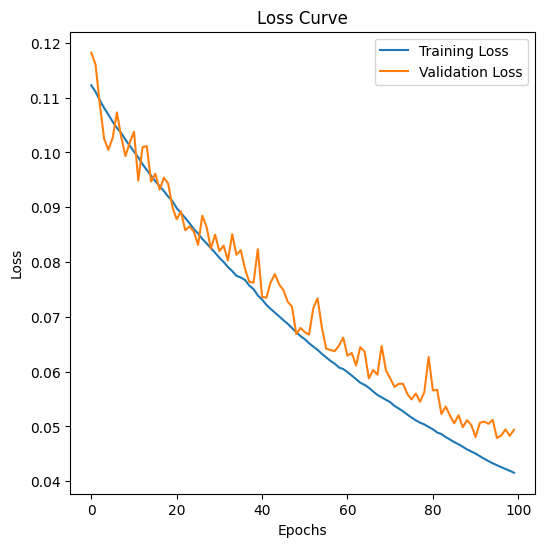

In [23]:
# Plot loss curves
plt.figure(figsize=(6, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


---
## <span style="color:brown"> 5. Perform the inference on the test dataset


### <span style="color:brown"> 5.1 Load the weight of the best model
You could use other weights for your model...

In [32]:
# To load and use the best model

input_shape = (3, width, height)  # This is the shape of the input image to the network
num_classes = 1  # This is the number of output classes
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32  # This is the number of channels in the first layer of the network

#model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(device)

model_weights_path = "best_model_carvana.pth"
model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

Then, we perform the inference on a sample from the test dataset and plot the prediction.
Run the following cell many times to test several images.
**Take care of the dimensions of tensors and data !...**


### <span style="color:brown"> 5.2 Test and visualized the results on one sample of the test_dataset

We compare the computation of Dice and IoU metrics using two approaches:
1. **Custom Functions**: Defined directly in the code.
2. **MONAI Metrics**: Utilizing the built-in metrics provided by the MONAI library.

In [33]:
num_workers = os.cpu_count() - 1
print("num_worker s=",num_workers)

# Create test_dataloader2, batch_size=1, just for the display of the following cell
test_dataloader2 = DataLoader(
    test_dataset, 
    batch_size=1, 
    pin_memory=torch.cuda.is_available(), 
    shuffle=False
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader2)

num_worker s= 15


Image shape: torch.Size([1, 1, 304, 752]) Label shape: torch.Size([1, 1, 304, 752])


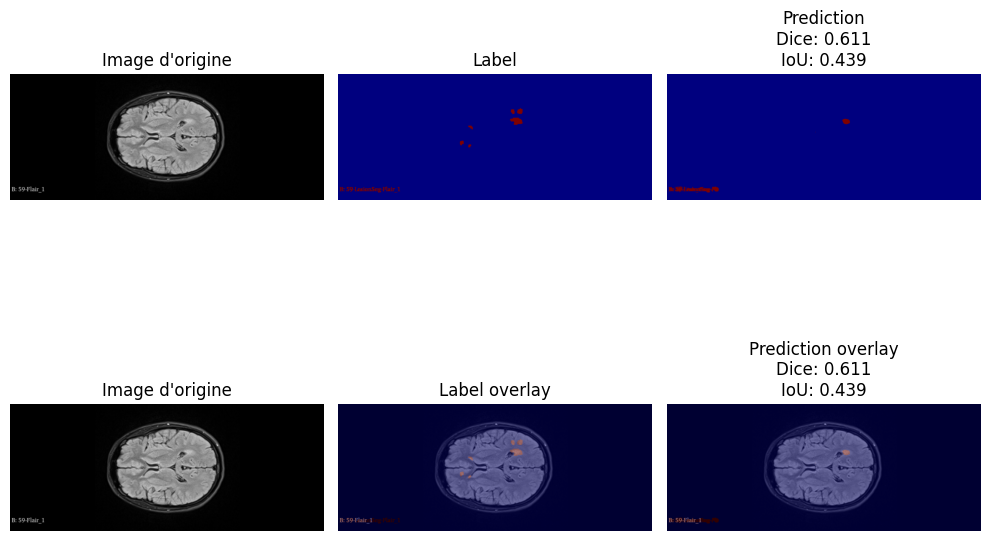

dice_metric_result (Monai) : 0.611
iou_metric_result  (Monai) : 0.439


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU

# Initialisation des métriques MONAI
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False)
dice_metric.reset()
iou_metric.reset()

# Fonctions de calcul Dice et IoU avec NumPy
def dice_score(pred, label):
    smooth = 1e-6
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)

def iou_score(pred, label):
    return jaccard_score(label.flatten(), pred.flatten())

# Préparation du modèle et du dataloader
model.to(device)
model.eval()

# Lecture d'un batch du test_dataloader
test_dataloader_iter = iter(test_dataloader)
batch_data = next(test_dataloader_iter)

with torch.no_grad():
    # Récupérer une image et son label
    image, label = batch_data[0][0].unsqueeze(0).to(device), batch_data[1][0].unsqueeze(0).to(device)
    print("Image shape:", image.shape, "Label shape:", label.shape)

    # Prédiction
    output = model(image)
    pred = (torch.sigmoid(output) > 0.3).float()

    # Métriques MONAI
    dice_metric(pred, label)
    iou_metric(pred, label)
    dice_metric_result = dice_metric.aggregate().item()
    iou_metric_result = iou_metric.aggregate().item()

    # Conversion en NumPy pour affichage
    pred = pred.squeeze().cpu().numpy()
    image = image.squeeze().cpu().numpy()
    label = label.squeeze().cpu().numpy()

    # Métriques NumPy
    dice = dice_score(pred, label)
    iou = iou_score(pred, label)

# Normalisation de l'image dans [0, 1]
image = (image + 1) / 2.0

# Affichage
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Première ligne : image, label, prédiction
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Image d'origine")
axes[0, 0].axis('off')

axes[0, 1].imshow(label, cmap='jet')
axes[0, 1].set_title("Label")
axes[0, 1].axis('off')

axes[0, 2].imshow(pred, cmap='jet')
axes[0, 2].set_title(f"Prediction\nDice: {dice:.3f}\nIoU: {iou:.3f}")
axes[0, 2].axis('off')

# Deuxième ligne : overlay
axes[1, 0].imshow(image, cmap='gray')
axes[1, 0].set_title("Image d'origine")
axes[1, 0].axis('off')

axes[1, 1].imshow(image, cmap='gray')
axes[1, 1].imshow(label, cmap='jet', alpha=0.4)
axes[1, 1].set_title("Label overlay")
axes[1, 1].axis('off')

axes[1, 2].imshow(image, cmap='gray')
axes[1, 2].imshow(pred, cmap='jet', alpha=0.4)
axes[1, 2].set_title(f"Prediction overlay\nDice: {dice:.3f}\nIoU: {iou:.3f}")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"dice_metric_result (Monai) : {dice_metric_result:.3f}")
print(f"iou_metric_result  (Monai) : {iou_metric_result:.3f}")


---
### <span style="color:brown"> 5.3 Computing Metrics on the Entire Test Dataset

In this section, we evaluate the segmentation accuracy across the entire test dataset.

Various metrics can be used for this purpose (refer to your lecture notes for details). You are encouraged to explore and implement additional metrics to test their performance.

### Metrics Used:
- **Dice Score**: Used here to measure segmentation accuracy.
- **IoU Metric**: Add your own user-defined implementation to compute IoU.
- **MONAI Metrics**: Experiment with MONAI's built-in metrics for comparison.
    (https://docs.monai.io/en/stable/metrics.html

In [61]:
# Custom functions
# Implementation 2: Dice Coefficient ( PyTorch version- Tensor operations)
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()
    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1
    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

# Implementation 1: Dice Score (NumPy Version - Array operations)
def dice_score(pred, label):
    smooth = 1e-6
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)
    
#  IoU Score (Intersection over Union)  (NumPy Version - Array operations)
def iou_score(pred, label):
    return jaccard_score(label.flatten(), pred.flatten())

test_running_loss = 0
test_running_dc1 = 0
test_running_dc2 = 0  # comparison with dice_score function

model.eval()
with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        if idx==0:
            print("0. img.shape:", img.shape,"0. mask.shape:",mask.shape)
        y_pred = model(img)
        loss = criterion(y_pred, mask)
        dc1 = dice_coefficient(y_pred, mask)
        
        y_pred = (torch.sigmoid(y_pred) > 0.3).float()
        np_mask = mask.squeeze(dim=0).squeeze(dim=0).detach().cpu().numpy()  # Same here
        np_y_pred = y_pred.squeeze(dim=0).squeeze(dim=0).detach().cpu().numpy()  # Sequentially remove the first two dimensions
        if idx==0:
            print("1.y_pred.shape:", y_pred.shape, "1. mask.shape:", mask.shape,"1. np_y_pred:", pred.shape)
        dc2 = dice_score(np_y_pred, np_mask)
       
        test_running_loss += loss.item()
        test_running_dc1 += dc1.item()
        test_running_dc2 += dc2.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc1 = test_running_dc1 / (idx + 1)
    test_dc2 = test_running_dc2 / (idx + 1)

print(f"Final Dice Metric 1 : {test_dc1:.3f}")
print(f"Final Dice Metric 2  : {test_dc2:.3f}")
print(f"test Loss : {test_loss:.3f}")

""" Essai Dice et IoU de Monai à revoir, à ne pas effacer !!!!"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import  DiceMetric, MeanIoU

# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metrics initialisation
dice_metric = DiceMetric(include_background=True, reduction="mean")
iou_metric = MeanIoU(include_background=True)  # No num_classes argument

# Dice and IoU metrics from monai, reset before use
dice_metric.reset()
iou_metric.reset()




  0%|                                                | 0/1 [00:00<?, ?it/s]

0. img.shape: torch.Size([6, 1, 304, 752]) 0. mask.shape: torch.Size([6, 1, 304, 752])


100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]

1.y_pred.shape: torch.Size([6, 1, 304, 752]) 1. mask.shape: torch.Size([6, 1, 304, 752]) 1. np_y_pred: (304, 752)
Final Dice Metric 1 : 0.242
Final Dice Metric 2  : 0.633
test Loss : 0.094


### 5.4 Hidden

In [65]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU
from medpy.metric.binary import hd95

# --- Fonctions personnalisées ---
def dice_score(pred, label):
    smooth = 1e-6
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)

def iou_score(pred, label):
    return jaccard_score(label.flatten(), pred.flatten())

def compute_hd95(pred, label):
    try:
        return hd95(pred.astype(bool), label.astype(bool))
    except:
        return np.nan  # En cas de masque vide

# Liste des seuils à tester
thresholds = np.arange(0.2, 0.51, 0.05)
results = {}

model.eval()
with torch.no_grad():
    for threshold in thresholds:
        print(f"\nÉvaluation pour le seuil {threshold:.2f}")
        
        # Réinitialiser les métriques MONAI
        dice_metric = DiceMetric(include_background=False, reduction="mean")
        iou_metric = MeanIoU(include_background=False)
        dice_metric.reset()
        iou_metric.reset()

        test_running_loss = 0
        test_running_dice = 0
        test_running_iou = 0
        test_running_hd95 = 0
        hd95_count = 0

        for idx, img_mask in enumerate(tqdm(test_dataloader, desc=f"Seuil {threshold:.2f}", leave=False)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            output = model(img)
            loss = criterion(output, mask)

            # Sigmoid + seuillage
            y_pred = (torch.sigmoid(output) > threshold).float()

            # MONAI metrics
            dice_metric(y_pred, mask)
            iou_metric(y_pred, mask)

            # Conversion pour calculs personnalisés
            np_mask = mask.cpu().numpy().squeeze(1)
            np_pred = y_pred.cpu().numpy().squeeze(1)

            for p, m in zip(np_pred, np_mask):
                test_running_dice += dice_score(p, m)
                test_running_iou += iou_score(p, m)

                hd = compute_hd95(p, m)
                if not np.isnan(hd):
                    test_running_hd95 += hd
                    hd95_count += 1

            test_running_loss += loss.item()

        n_batches = idx + 1
        n_samples = len(test_dataloader.dataset)

        # Résultats moyens
        avg_loss = test_running_loss / n_batches
        avg_dice = test_running_dice / n_samples
        avg_iou = test_running_iou / n_samples
        avg_hd95 = test_running_hd95 / hd95_count if hd95_count > 0 else np.nan
        dice_monai = dice_metric.aggregate().item()
        iou_monai = iou_metric.aggregate().item()

        # Stockage
        results[threshold] = {
            "loss": avg_loss,
            "dice_custom": avg_dice,
            "iou_custom": avg_iou,
            "dice_monai": dice_monai,
            "iou_monai": iou_monai,
            "hd95": avg_hd95
        }

# --- Affichage final ---
print("\n📊 Résultats par seuil :")
for t, metrics in results.items():
    print(f"\nSeuil = {t:.2f}")
    print(f"  Loss           : {metrics['loss']:.4f}")
    print(f"  Dice (custom)  : {metrics['dice_custom']:.4f}")
    print(f"  IoU  (custom)  : {metrics['iou_custom']:.4f}")
    print(f"  Dice (MONAI)   : {metrics['dice_monai']:.4f}")
    print(f"  IoU  (MONAI)   : {metrics['iou_monai']:.4f}")
    print(f"  HD95 (MedPy)   : {metrics['hd95']:.2f}")



Évaluation pour le seuil 0.20



Évaluation pour le seuil 0.25



Évaluation pour le seuil 0.30



Évaluation pour le seuil 0.35



Évaluation pour le seuil 0.40



Évaluation pour le seuil 0.45



Évaluation pour le seuil 0.50



📊 Résultats par seuil :

Seuil = 0.20
  Loss           : 0.0941
  Dice (custom)  : 0.5797
  IoU  (custom)  : 0.4099
  Dice (MONAI)   : 0.5797
  IoU  (MONAI)   : 0.4099
  HD95 (MedPy)   : 34.81

Seuil = 0.25
  Loss           : 0.0941
  Dice (custom)  : 0.6217
  IoU  (custom)  : 0.4525
  Dice (MONAI)   : 0.6217
  IoU  (MONAI)   : 0.4525
  HD95 (MedPy)   : 31.75

Seuil = 0.30
  Loss           : 0.0941
  Dice (custom)  : 0.6415
  IoU  (custom)  : 0.4741
  Dice (MONAI)   : 0.6415
  IoU  (MONAI)   : 0.4741
  HD95 (MedPy)   : 34.41

Seuil = 0.35
  Loss           : 0.0941
  Dice (custom)  : 0.6394
  IoU  (custom)  : 0.4727
  Dice (MONAI)   : 0.6394
  IoU  (MONAI)   : 0.4727
  HD95 (MedPy)   : 45.00

Seuil = 0.40
  Loss           : 0.0941
  Dice (custom)  : 0.6029
  IoU  (custom)  : 0.4350
  Dice (MONAI)   : 0.6029
  IoU  (MONAI)   : 0.4350
  HD95 (MedPy)   : 78.10

Seuil = 0.45
  Loss           : 0.0941
  Dice (custom)  : 0.4761
  IoU  (custom)  : 0.3162
  Dice (MONAI)   : 0.4761
  IoU  (MONA

In [ ]:
# Toolkit function
# Windows may create an hidden file "Thumbs.db". If the error occurs, run the following funtion
def delete_thumbs_db(directory):
    # Parcours de tous les fichiers et sous-dossiers du répertoire
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == "Thumbs.db":
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Supprimé : {file_path}")
                except Exception as e:
                    print(f"Erreur lors de la suppression de {file_path} : {e}")

# Remplacez 'chemin/vers/dossier' par le chemin réel de votre répertoire
delete_thumbs_db("data/carvana/train")
delete_thumbs_db("data/carvana/train_masks")